<a href="https://colab.research.google.com/github/hamednasr/Computer-Vision-with-Python/blob/main/body_move_detection_for_game(nich).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import cv2
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

C:\Users\david\AppData\Local\Temp/ipykernel_17040/959349632.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
interpreter = tf.lite.Interpreter(model_path='movenets/lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()
input_size = 192
# input_size = 256

In [ ]:
actions = np.array(['jump','crouch','right_jump','left_jump','run'])
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'jump': 0, 'crouch': 1, 'right_jump': 2, 'left_jump': 3, 'run': 4}

In [ ]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

In [ ]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

In [ ]:
def movenet_keypoints(image, input_size=192):
    
    # Reshape image
    img = tf.image.resize_with_pad(np.expand_dims(image, axis=0), input_size,input_size)
    input_image = tf.cast(img, dtype=tf.float32)

    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Make predictions 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    
    return keypoints_with_scores   

# draw keypoints on cam video:

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Reshape image
    
    img = tf.image.resize_with_pad(np.expand_dims(frame, axis=0), input_size,input_size)
    input_image = tf.cast(img, dtype=tf.float32)
    
    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Make predictions 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
#     print(np.squeeze(keypoints_with_scores).flatten())
    # Rendering 
    draw_connections(frame, keypoints_with_scores, EDGES, 0.2)
    draw_keypoints(frame, keypoints_with_scores, 0.2)
    
    cv2.imshow('MoveNet Lightning', frame)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

# record data:

## jump:

In [ ]:
data_path = 'C:\\Users\\david\\Google Drive\\Colab Notebooks\\Computer Vision\\bodymove_data'
no_videos = 60
sequences_length = 20

In [ ]:
for video in range(no_videos):
    try:
        os.makedirs(os.path.join(data_path,'jump',str(video)))  
    except:
        pass        

In [ ]:
cap = cv2.VideoCapture(0)
    
for video in range(no_videos):
    for frame_num in range(sequences_length):

        ret, frame = cap.read()

        keypoints_with_scores = movenet_keypoints(frame, input_size=192)
        draw_keypoints(frame, keypoints_with_scores, 0.2)
        draw_connections(frame, keypoints_with_scores, EDGES, 0.2)

        if frame_num==0:
            cv2.putText(frame,'COLLECTION START for JUMP',(150,200),
                        cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),4,cv2.LINE_AA)
            cv2.putText(frame,f'collecting frames for jump video numer {video}',(15,12),
                        cv2.FONT_HERSHEY_COMPLEX,.5,(0,255,0),1,cv2.LINE_AA)
            cv2.imshow('Webcam Feed', frame)
            cv2.waitKey(2000)

        else:
            cv2.putText(frame,f'collecting frames for jump video numer {video}',(15,12),
            cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),1,cv2.LINE_AA)

            cv2.imshow('Webcam Feed', frame)
            
            
        keypoints = np.squeeze(keypoints_with_scores).flatten()

        npy_path = os.path.join(data_path,'jump',str(video),str(frame_num))
        np.save(npy_path,keypoints)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## crouch:

In [ ]:
data_path = 'C:\\Users\\david\\Google Drive\\Colab Notebooks\\Computer Vision\\bodymove_data'
no_videos = 60
sequences_length = 20

In [ ]:
for video in range(no_videos):
    try:
        os.makedirs(os.path.join(data_path,'crouch',str(video)))  
    except:
        pass        

In [ ]:
cap = cv2.VideoCapture(0)
    
for video in range(no_videos):
    for frame_num in range(sequences_length):

        ret, frame = cap.read()

        keypoints_with_scores = movenet_keypoints(frame, input_size=192)
        draw_keypoints(frame, keypoints_with_scores, 0.2)
        draw_connections(frame, keypoints_with_scores, EDGES, 0.2)

        if frame_num==0:
            cv2.putText(frame,'COLLECTION START for CROUCH',(150,200),
                        cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),4,cv2.LINE_AA)
            cv2.putText(frame,f'collecting frames for crouch video numer {video}',(15,12),
                        cv2.FONT_HERSHEY_COMPLEX,.5,(0,255,0),1,cv2.LINE_AA)
            cv2.imshow('Webcam Feed', frame)
            cv2.waitKey(2000)

        else:
            cv2.putText(frame,f'collecting frames for crouch video numer {video}',(15,12),
            cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),1,cv2.LINE_AA)

            cv2.imshow('Webcam Feed', frame)
            
            
        keypoints = np.squeeze(keypoints_with_scores).flatten()

        npy_path = os.path.join(data_path,'crouch',str(video),str(frame_num))
        np.save(npy_path,keypoints)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## right jump:

In [ ]:
data_path = 'C:\\Users\\david\\Google Drive\\Colab Notebooks\\Computer Vision\\bodymove_data'
no_videos = 60
sequences_length = 20

In [ ]:
for video in range(no_videos):
    try:
        os.makedirs(os.path.join(data_path,'right_jump',str(video)))  
    except:
        pass        

In [ ]:
cap = cv2.VideoCapture(0)
    
for video in range(no_videos):
    for frame_num in range(sequences_length):

        ret, frame = cap.read()

        keypoints_with_scores = movenet_keypoints(frame, input_size=192)
        draw_keypoints(frame, keypoints_with_scores, 0.2)
        draw_connections(frame, keypoints_with_scores, EDGES, 0.2)

        if frame_num==0:
            cv2.putText(frame,'COLLECTION START for RIGHT_JUMP',(150,200),
                        cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),4,cv2.LINE_AA)
            cv2.putText(frame,f'collecting frames for right_jump video numer {video}',(15,12),
                        cv2.FONT_HERSHEY_COMPLEX,.5,(0,255,0),1,cv2.LINE_AA)
            cv2.imshow('Webcam Feed', frame)
            cv2.waitKey(2000)

        else:
            cv2.putText(frame,f'collecting frames for right_jump video numer {video}',(15,12),
            cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),1,cv2.LINE_AA)

            cv2.imshow('Webcam Feed', frame)
            
            
        keypoints = np.squeeze(keypoints_with_scores).flatten()

        npy_path = os.path.join(data_path,'right_jump',str(video),str(frame_num))
        np.save(npy_path,keypoints)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## left jump:

In [ ]:
data_path = 'C:\\Users\\david\\Google Drive\\Colab Notebooks\\Computer Vision\\bodymove_data'
no_videos = 60
sequences_length = 20

In [ ]:
for video in range(no_videos):
    try:
        os.makedirs(os.path.join(data_path,'left_jump',str(video)))  
    except:
        pass        

In [ ]:
cap = cv2.VideoCapture(0)
    
for video in range(no_videos):
    for frame_num in range(sequences_length):

        ret, frame = cap.read()

        keypoints_with_scores = movenet_keypoints(frame, input_size=192)
        draw_keypoints(frame, keypoints_with_scores, 0.2)
        draw_connections(frame, keypoints_with_scores, EDGES, 0.2)

        if frame_num==0:
            cv2.putText(frame,'COLLECTION START for LEFT_JUMP',(150,200),
                        cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),4,cv2.LINE_AA)
            cv2.putText(frame,f'collecting frames for left_jump video numer {video}',(15,12),
                        cv2.FONT_HERSHEY_COMPLEX,.5,(0,255,0),1,cv2.LINE_AA)
            cv2.imshow('Webcam Feed', frame)
            cv2.waitKey(2000)

        else:
            cv2.putText(frame,f'collecting frames for left_jump video numer {video}',(15,12),
            cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),1,cv2.LINE_AA)

            cv2.imshow('Webcam Feed', frame)
            
            
        keypoints = np.squeeze(keypoints_with_scores).flatten()

        npy_path = os.path.join(data_path,'left_jump',str(video),str(frame_num))
        np.save(npy_path,keypoints)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## run:

In [ ]:
data_path = 'C:\\Users\\david\\Google Drive\\Colab Notebooks\\Computer Vision\\bodymove_data'
no_videos = 60
sequences_length = 20

In [ ]:
for video in range(no_videos):
    try:
        os.makedirs(os.path.join(data_path,'run',str(video)))  
    except:
        pass        

In [ ]:
cap = cv2.VideoCapture(0)
    
for video in range(no_videos):
    for frame_num in range(sequences_length):

        ret, frame = cap.read()

        keypoints_with_scores = movenet_keypoints(frame, input_size=192)
        draw_keypoints(frame, keypoints_with_scores, 0.2)
        draw_connections(frame, keypoints_with_scores, EDGES, 0.2)

        if frame_num==0:
            cv2.putText(frame,'COLLECTION START for run',(150,200),
                        cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),4,cv2.LINE_AA)
            cv2.putText(frame,f'collecting frames for run video numer {video}',(15,12),
                        cv2.FONT_HERSHEY_COMPLEX,.5,(0,255,0),1,cv2.LINE_AA)
            cv2.imshow('Webcam Feed', frame)
            cv2.waitKey(2000)

        else:
            cv2.putText(frame,f'collecting frames for run video numer {video}',(15,12),
            cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),1,cv2.LINE_AA)

            cv2.imshow('Webcam Feed', frame)
            
            
        keypoints = np.squeeze(keypoints_with_scores).flatten()

        npy_path = os.path.join(data_path,'run',str(video),str(frame_num))
        np.save(npy_path,keypoints)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

# preprocess data and create labels and features:

In [ ]:
actions

array(['jump', 'crouch', 'right_jump', 'left_jump', 'run'], dtype='<U10')

In [ ]:
sequences = []
labels = []

for action in actions:
  for video in range(no_videos):
    window = []
    for frame_num in range(sequences_length):
      res = np.load(os.path.join(data_path,action,str(video),f'{frame_num}.npy'))
      window.append(res)
    sequences.append(window)
    labels.append(label_map[action])

In [ ]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [ ]:
print(np.array(window).shape)
print(np.array(sequences).shape)
print(np.array(labels).shape)

(20, 51)
(300, 20, 51)
(300,)


In [ ]:
X = np.array(sequences)
y = np.array(labels)

In [ ]:
X.shape

(300, 20, 51)

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=22)

In [ ]:
X_train.shape, X_test.shape

((255, 20, 51), (45, 20, 51))

# create and train deep learning model:

## create DL model:

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs')

In [ ]:
model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(64,activation='relu', return_sequences=True),
                    tf.keras.layers.LSTM(128,activation='relu', return_sequences=True),
                    tf.keras.layers.LSTM(64,activation='relu', return_sequences=False),
                    tf.keras.layers.Dense(64,activation='relu'),
                    tf.keras.layers.Dense(32,activation='relu'),
                    tf.keras.layers.Dense(actions.shape[0],activation='softmax')
                    ])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'sparse_categorical_crossentropy', 
              metrics='accuracy' )

## train DL model:

In [ ]:
model.fit(X_train,y_train,epochs=50,callbacks=tensorboard)

Epoch 1/50
8/8 [==============================] - 5s 48ms/step - loss: 1.6038 - accuracy: 0.2588
Epoch 2/50
8/8 [==============================] - 0s 46ms/step - loss: 1.5495 - accuracy: 0.3451
Epoch 3/50
8/8 [==============================] - 0s 59ms/step - loss: 1.4383 - accuracy: 0.3490
Epoch 4/50
8/8 [==============================] - 0s 49ms/step - loss: 1.2977 - accuracy: 0.4039
Epoch 5/50
8/8 [==============================] - 0s 48ms/step - loss: 1.2088 - accuracy: 0.5412
Epoch 6/50
8/8 [==============================] - 0s 54ms/step - loss: 1.1799 - accuracy: 0.4706
Epoch 7/50
8/8 [==============================] - 0s 56ms/step - loss: 1.1002 - accuracy: 0.6510
Epoch 8/50
8/8 [==============================] - 0s 54ms/step - loss: 0.8306 - accuracy: 0.6392
Epoch 9/50
8/8 [==============================] - 0s 49ms/step - loss: 0.9040 - accuracy: 0.6353
Epoch 10/50
8/8 [==============================] - 0s 53ms/step - loss: 0.7681 - accuracy: 0.6824
Epoch 11/50
8/8 [============

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 64)            29696     
                                                                 
 lstm_4 (LSTM)               (None, 20, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 184,325
Trainable params: 184,325
Non-tr

In [ ]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 1s 13ms/step - loss: 0.0582 - accuracy: 0.9778


[0.0581539086997509, 0.9777777791023254]

In [ ]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_pred

array([1, 0, 2, 3, 0, 4, 4, 3, 2, 2, 2, 1, 1, 4, 4, 1, 0, 3, 3, 3, 0, 3,
       4, 4, 3, 0, 0, 4, 2, 4, 0, 4, 2, 3, 4, 2, 1, 3, 3, 1, 4, 1, 0, 2,
       2], dtype=int64)

In [ ]:
y_test

array([1, 0, 2, 3, 0, 4, 4, 4, 2, 2, 2, 1, 1, 4, 4, 1, 0, 3, 3, 3, 0, 3,
       4, 4, 3, 0, 0, 4, 2, 4, 0, 4, 2, 3, 4, 2, 1, 3, 3, 1, 4, 1, 0, 2,
       2])

In [ ]:
model.save('C:\\Users\\david\\Google Drive\\Colab Notebooks\\Computer Vision\\gameaction.h5')

In [ ]:
# model.load_weights('C:\\Users\\david\\Google Drive\\Colab Notebooks\\Computer Vision\\action.h5')   

## evaluate DL model:

In [ ]:
actions

array(['jump', 'crouch', 'right_jump', 'left_jump', 'run'], dtype='<U10')

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 8,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0],
       [ 0,  0,  9,  0,  0],
       [ 0,  0,  0,  9,  0],
       [ 0,  0,  0,  1, 11]], dtype=int64)

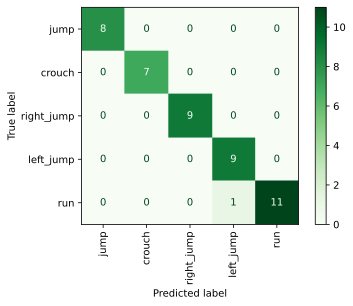

In [ ]:
disp = ConfusionMatrixDisplay(cm , display_labels= actions)

disp.plot(cmap='Greens' , xticks_rotation='vertical');

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         9
           3       0.90      1.00      0.95         9
           4       1.00      0.92      0.96        12

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

